In [7]:
import os
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import ML libraries
from sklearn.model_selection import train_test_split

In [8]:
# set relative directory paths
DATA_DIR = os.path.join(os.getcwd(), '..', 'data')
DATA_LOOKUPS_DIR = os.path.join(DATA_DIR, 'lookups')
DATA_RAW_DIR = os.path.join(DATA_DIR, 'raw')
DATA_PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
DATA_TRAIN_DIR = os.path.join(DATA_PROCESSED_DIR, 'train')
DATA_TEST_DIR = os.path.join(DATA_PROCESSED_DIR, 'test')
key_chord_mapping = pd.read_csv(os.path.join(DATA_LOOKUPS_DIR, 'musical_key-triad_chord_mapping.csv'), index_col='Degree')

In [9]:
def filter_sections_by_length(df, t_l, t_h):
    '''
    keep sections from df whose lengths are in set [t_l, t_h] inclusive
    '''
    df['section_length'] = df.chords.apply(len)
    df = df[(df.section_length >= t_l) & (df.section_length <= t_h)]
    
    return df.drop(columns='section_length')


def remove_duplicates(df):
    '''
    remove duplicate entries for each song
    '''
    song_ids = df.id.unique()
    df_unique = pd.DataFrame()
    df.chords = df.chords.apply(str)
    for i in song_ids:
        sec = df[df.id == i].chords.unique()
        song_id_array = [i] * len(sec)
        data = {'song_id': song_id_array, 'chords': sec}
        df_unique = df_unique.append(pd.DataFrame(data))
    df_unique.chords = df_unique.chords.apply(ast.literal_eval)
    
    return df_unique


def extend_section_lengths(sections, L):
    '''
    extends chords in series to length, L
    sections, s, will be repeated and truncated at length l
    '''
    long_sections = []
    for s in sections:
        long_sec = []
        if len(s) == 0:
            continue
        while len(long_sec) < L:
            long_sec.extend(s)
        long_sections.append(long_sec[:L])
        
    return pd.Series(long_sections)

In [10]:
df = pd.read_csv(os.path.join(DATA_RAW_DIR, 'chords_by_section.csv'), index_col='Unnamed: 0')
df = df[['id', 'chords_numeric']]
df.chords_numeric = df.chords_numeric.apply(ast.literal_eval)
df.rename(columns={'chords_numeric': 'chords'}, inplace=True)

MIN_SECTION_LENGTH = 2
MAX_SECTION_LENGTH = 16
df = filter_sections_by_length(df, MIN_SECTION_LENGTH, MAX_SECTION_LENGTH)
df = remove_duplicates(df)
df.chords = extend_section_lengths(df.chords, 20)

df = df.reset_index().drop(columns='index')

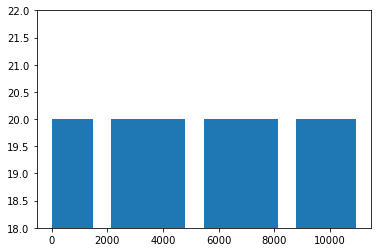

In [11]:
df['section_length'] = df.chords.apply(len)
plt.figure();
plt.ylim(ymax=max(df.section_length) + 2, ymin=min(df.section_length) - 2);
plt.bar(df.index, df.section_length);

In [12]:
df

,song_id,chords,section_length
0,198052,"[1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, ...",20
1,198052,"[1, 6, 1, 6, 4, 5, 1, 5, 1, 4, 5, 6, 4, 5, 1, ...",20
2,198052,"[4, 6, 4, 1, 5, 1, 6, 1, 6, 4, 6, 4, 1, 5, 1, ...",20
3,198052,"[1, 6, 1, 6, 4, 5, 1, 5, 1, 4, 5, 6, 4, 5, 4, ...",20
4,1956589,"[1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, ...",20
...,...,...,...
10949,58277,"[1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, ...",20
10950,141670,"[1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, ...",20
10951,141670,"[1, 6, 1, 6, 4, 5, 1, 5, 1, 4, 5, 6, 4, 5, 1, ...",20
10952,141670,"[4, 6, 4, 1, 5, 1, 6, 1, 6, 4, 6, 4, 1, 5, 1, ...",20


In [297]:
X = df.chords

# Save ML datasets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

'''
X_train.to_csv(os.path.join(DATA_PROCESSED_DIR, 'train', 'X_train.csv'), header=True)
y_train.to_csv(os.path.join(DATA_PROCESSED_DIR, 'train', 'y_train.csv'), header=True)
X_test.to_csv(os.path.join(DATA_PROCESSED_DIR, 'test', 'X_test.csv'), header=True)
y_test.to_csv(os.path.join(DATA_PROCESSED_DIR, 'test', 'y_test.csv'), header=True)
''';

In [338]:
# create RNN architecture/model


In [4]:
# train model


In [5]:
# test model


In [6]:
# plot outputs / determine metrics


In [7]:
# create two dummy progressions of various lengths
